In [23]:

!pip install ipywidgets --quiet
import os, sys, shutil


if os.path.exists("RealOrAI-DogDetector"):
    shutil.rmtree("RealOrAI-DogDetector")

!git clone https://github.com/zhaoq23/RealOrAI-DogDetector.git

# Change directory to repo and add to Python path
os.chdir("RealOrAI-DogDetector")
sys.path.append(".")


import torch
from IPython.display import display
import ipywidgets as widgets
from models import BayesianMLP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Cloning into 'RealOrAI-DogDetector'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 200 (delta 56), reused 21 (delta 21), pack-reused 121 (from 2)
Receiving objects: 100% (200/200), 114.69 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [24]:
!pip install ipywidgets --quiet

import torch
from torch.utils.data import DataLoader
from IPython.display import display
import ipywidgets as widgets
from models import BayesianMLP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
def load_model(model_path="plusdiff_model.pt"):
    model = BayesianMLP()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model


In [26]:
def classify_feature_tensor(tensor, model):
    tensor = tensor.to(device)
    with torch.no_grad():
        output = model(tensor)  # Make sure you're using the input variable name 'tensor'
        prob = torch.sigmoid(output).item()
        label = "Real 🐶" if prob > 0.5 else "AI-generated 🤖"
        print(f"Prediction: {label} (Confidence: {prob:.2f})")



In [27]:
upload = widgets.FileUpload(accept='.pt', multiple=False)

def on_upload_change(change):
    if upload.value:
        file_info = next(iter(upload.value.values()))
        with open("temp.pt", "wb") as f:
            f.write(file_info['content'])

        # Load the .pt file and extract features
        data = torch.load("temp.pt")
        if isinstance(data, tuple):  # (features, label)
            tensor = data[0]
        else:
            tensor = data

        if len(tensor.shape) == 1:
            tensor = tensor.unsqueeze(0)  # Add batch dimension if needed

        # Add padding fix
        if tensor.shape[1] == 384:
            padding = torch.zeros((tensor.shape[0], 1))
            tensor = torch.cat([tensor, padding], dim=1)

        # Load model and classify
        model = load_model()
        classify_feature_tensor(tensor, model)

upload.observe(on_upload_change, names='value')
display(upload)


FileUpload(value={}, accept='.pt', description='Upload')

FileUpload(value={}, accept='image/*', description='Upload')

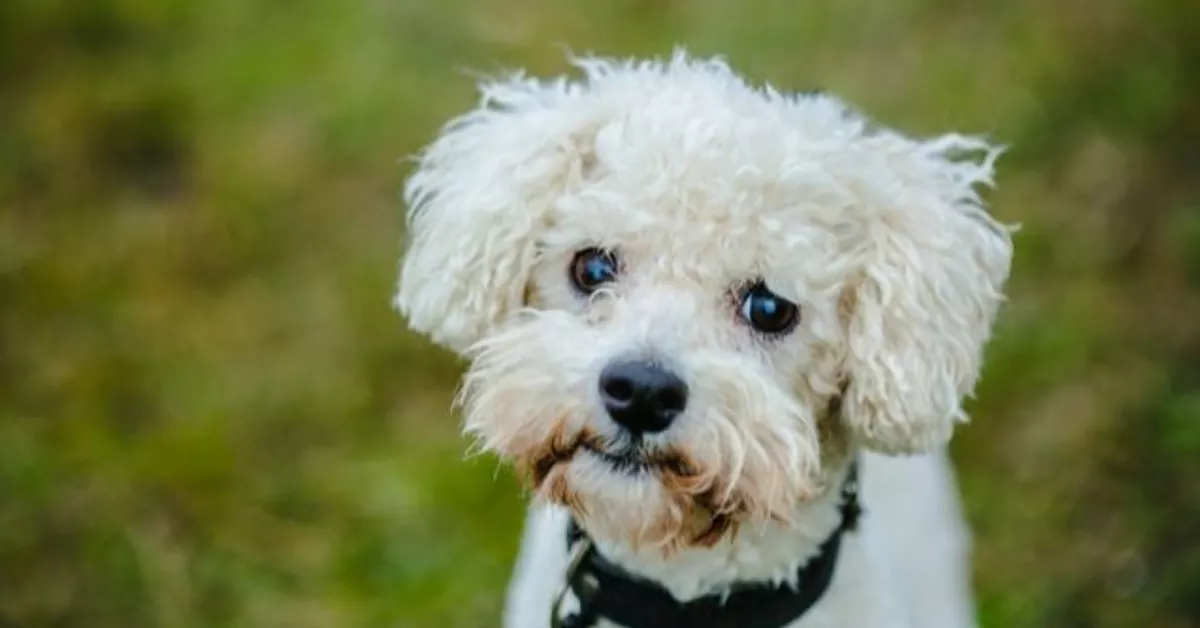

Prediction: Real 🐶 (Confidence: 0.84)


In [32]:
import io
from PIL import Image
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModel
import torch.nn as nn
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display

# Upload image
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

# Load feature extractor and backbone
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
feature_model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)

# Load classifier
model = load_model("plusdiff_model.pt").to(device)

# Quick projection from 768 → 384 (simulates training setup)
projection = nn.Linear(768, 384).to(device)

def extract_features(image):
    # Step 1: Extract 768-dim features from ViT
    inputs = extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        vit_features = feature_model(**inputs).last_hidden_state.mean(dim=1)

    # Step 2: Project down to 384
    projected = projection(vit_features)

    # Step 3: Pad to 385
    padding = torch.zeros((projected.shape[0], 1), device=device)
    features_385 = torch.cat([projected, padding], dim=1)

    return features_385

def classify_uploaded_image(change):
    if len(uploader.value) > 0:
        file_info = list(uploader.value.values())[0]
        image_bytes = file_info['content']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        display(image)

        # Extract and classify
        features = extract_features(image)
        with torch.no_grad():
            output = model(features)
            prob = torch.sigmoid(output).item()
            label = "AI-generated 🤖" if prob > 0.5 else "Real 🐶"

        print(f"Prediction: {label} (Confidence: {prob:.2f})")

uploader.observe(classify_uploaded_image, names='value')


FileUpload(value={}, accept='image/*', description='Upload')

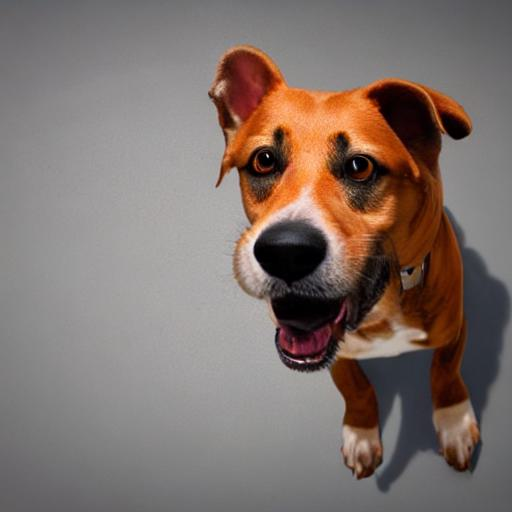

Prediction: AI-generated 🤖 (Confidence: 0.92)


In [35]:
def classify_uploaded_image(change):
    if len(uploader.value) > 0:
        file_info = list(uploader.value.values())[0]
        image_bytes = file_info['content']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        display(image)

        # Extract and classify
        features = extract_features(image)
        with torch.no_grad():
            output = model(features)
            prob = torch.sigmoid(output).item()
            label = "AI-generated 🤖" if prob > 0.5 else "Real 🐶"

        print(f"Prediction: {label} (Confidence: {prob:.2f})")

uploader.observe(classify_uploaded_image, names='value')